### Wave Equation

Problem setting: one-dimensional waves on a string of length L

$$
  \frac{d^2u}{dt^2} = c^2\frac{d^2u}{dx^2}   x\in(0,L), t\in(0,T]
$$

with two initial conditions:

1. the initial shape of the string

    $$
    u(x,0) = I(x)
   $$

2. reflecting that the initial velocity of the string is zero
$$
\frac{d}{dt}u(x,0) = 0
$$

and boundary conditions:
$$
u(0,t) = 0
$$

$$
u(L,t) = 0
$$


The constant c and the function I(x) must be prescribed

Concrete example

$$
u(x,0) = A \sin(\frac{\pi}{L} x)
$$

$$
u_e(0,t) = u_e(L,t) = 0
$$


analytic solution is

$$
u_e(x,y,t) = A \sin(\frac{\pi}{L} x)\cos(\frac{\pi}{L} ct) 
$$



In [1]:
import numpy as np
def initial(A, x):
    return A * np.sin((np.pi/L)*x)

def analytic(A,x,c, t):
    return A * np.sin((np.pi/L)*x)*np.cos((np.pi/L)*c*t)

A = 1.
L = 1
c = 1
x = np.linspace(0,1,100)
y0 = initial(A, x)
y = analytic(A, x, c, 1)

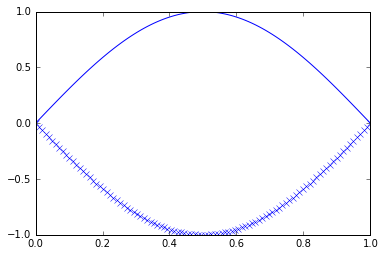

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x,y0,'b')
plt.plot(x,y, 'x')

In [3]:
from IPython.core.display import HTML
#css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
#HTML(url=css_file)

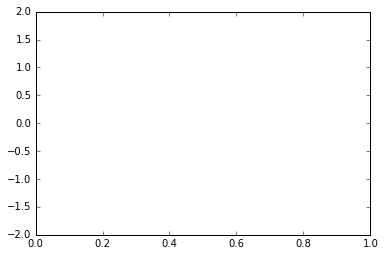

In [4]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-2,2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    c = 1
    x = np.linspace(0, 1, 500)
    #t = i/100.
    y =  A * np.sin((np.pi/L)*x)*np.cos((np.pi/L)*c*i)
    line.set_data(x, y)
    return line,


In [5]:
HTML(animation.FuncAnimation(fig, animate, init_func=init, interval=200, frames=50, blit=True).to_html5_video())

Discretization
$$
\frac{u_i^{n+1} - 2 u_i^n + u_i^{n-1}}{\delta t^2} = c^2 \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\delta x^2} 
$$

$$
u_i^{n+1} = 2 u_i^n - u_i^{n-1} + C^2  (u_{i+1}^n - 2u_i^n + u_{i-1}^n)
$$

$$
C = c \frac{\delta t}{\delta x}
$$

In [6]:
Nt = 100
Nx = 100
x, dx = np.linspace(0, 1, Nx, retstep=True)
t, dt = np.linspace(0,1, Nt, retstep=True)
c=1
C = c *dt/dx

In [7]:
from devito import TimeData, Operator
from sympy import Eq, solve
from sympy.abc import h, s

Nt = 500
L = 1
dx = 0.01
x = np.arange(0, L ,dx)
#dt = 1e-9
dt =0.009

c=1

#initial condition
u0 = initial(A, x)

#first step, du/dt = 0 ---> u_i_n-1 & u_i_n+1 are equal, v=0
u1 = np.zeros_like(u0)
u1[1:-1] = 2 * u0[1:-1] - u0[1:-1] + C**2 * (u0[2:] -2*u0[1:-1]+u0[0:-2])


nx = len(x)
# Allocate the grid and set initial condition
# Note: This should be made simpler through the use of defaults
u = TimeData(name='u', shape=(nx, ), time_order=2, space_order=2,time_dim=Nt,save=True)
u.data[0, :] = u0[:]
u.data[1, :] = u1[:]

In [8]:
(0.009**2)/dx**2

0.8099999999999998

In [9]:
# Derive the stencil according to devito conventions
eqn = Eq(u.dt2, c * u.dx2)
stencil = solve(eqn, u.forward)[0]
op = Operator([Eq(u.forward, stencil)], subs={h: dx, s: dt})

# Execute the generated Devito stencil operator
op.apply(u=u)

DSE: <filter object at 0x113732d30> [flops: 7, elapsed: 0.00] >>
     <filter object at 0x113732d30> [flops: 7, elapsed: 0.00] >>
     <filter object at 0x113732d30> [flops: 7, elapsed: 0.00] >>
     <filter object at 0x113732d30> [flops: 6, elapsed: 0.01] >>
     <filter object at 0x113732d30> [flops: 6, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: <filter object at 0x113787940> [elapsed: 0.00] >>
     <filter object at 0x113787940> [elapsed: 0.00] >>
     <filter object at 0x113787940> [elapsed: 0.00] >>
     <filter object at 0x113787940> [elapsed: 0.00] >>
     <filter object at 0x113787940> [elapsed: 0.00] >>
     <filter object at 0x113787a90> [elapsed: 0.01]
     [Total elapsed: 0.02 s]
ClangCompiler: compiled /var/folders/f3/c2wg4lkx1ms7_41c3qzz8x7nrdhbjw/T/devito-1893215804/74af425844a54f1ff756b4f6c9ef73d13b928c4b.c [0.10 s]
Section main<499,99> with OI=0.74 computed in 0.000 s [Perf: 3.75 GFlops/s]


PerformanceSummary([('main',
                     PerfEntry(time=7.9e-05, gflopss=3.751974683544304, oi=0.741015, itershape=[499, 99], datashape=[500, 100]))])

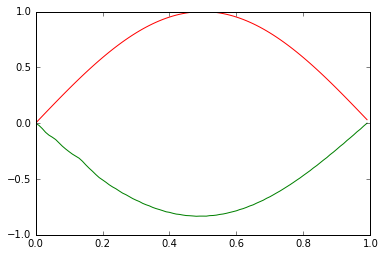

In [10]:
plt.plot(x,u0, '-r')
plt.plot(x,u.data[350,:], '-g')

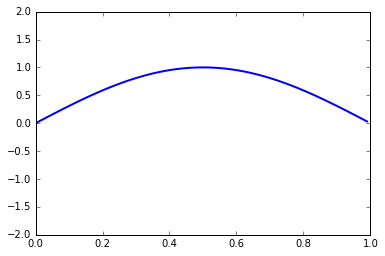

In [11]:
#plot the first step
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-2,2))
line, = ax.plot(x, u0, lw=2)

def do_steps(i):
    line.set_ydata(u.data[i,:])    # update data in plot
    fig.canvas.draw()# redraw the canvas
    return line,

In [12]:
HTML(animation.FuncAnimation(fig,do_steps, range(Nt),interval=10).to_html5_video())